In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from pygam import GAM, s, f, te, l

### Functions

In [2]:
def centralize_data(data, col):
    wm = lambda x: np.average(x, weights = data.loc[x.index, 'PA'])
    cols = ['IDfg', 'Season', 'Name', 'Age', 'PA', 'experience'] + [col]
    df = data.loc[:, cols]

    mean_results = df.groupby(['Season']).agg(weighted_mean = (col, wm))
    mean_results = mean_results.reset_index()
    df = df.merge(mean_results, on = 'Season')
    df[col + '_centralized'] = np.subtract(df[col], df['weighted_mean'])

    return df

In [3]:
def add_career_mean(data, col):
    cols = ['IDfg', 'Season', 'Name', 'Age', 'G', 'PA', 'experience'] + [col, col + '_lag']
    df = data.loc[:, cols]
    wm = lambda x: np.average(x, weights = df.loc[x.index, 'PA'])

    mean_result = df.groupby(['IDfg']).agg(weighted_mean = (col, wm))
    mean_result = mean_result.reset_index()
    mean_result.columns = ['IDfg', col + '_career_mean']
    df = df.merge(mean_result, on = 'IDfg', how = 'left')

    return df

In [4]:
def add_experience(data):
    tmp_df = data.groupby(['IDfg'])
    data['experience'] = tmp_df['Season'].diff().fillna(0.0)
    data['experience'] = data.groupby(['IDfg'])['experience'].cumsum()

    return data

In [5]:
def add_lag(data, col):
    tmp_df = data.groupby(['IDfg'])
    data[col + '_lag'] = tmp_df[col].shift(1)
    data = data.dropna()

    return data

In [6]:
def load_data(target, centralized = False):
    train_data = pd.read_csv('./data/hitter_train_data.csv')
    test_data = pd.read_csv('./data/hitter_test_data.csv')
    
    train_data = train_data.loc[(train_data['Age'] >= 20).values & (train_data['Age'] <= 40).values, :]
    test_data = test_data.loc[(test_data['Age'] >= 20).values & (test_data['Age'] <= 40).values, :]

    train_data = train_data.sort_values(by = ['Season', 'Name']).reset_index(drop = True)
    test_data = test_data.sort_values(by = ['Season', 'Name']).reset_index(drop = True)

    all_data = pd.concat([train_data, test_data])
    all_data = all_data.reset_index(drop = True)
    all_data = add_experience(all_data)
    
    if centralized:
        all_data = centralize_data(all_data, target)
        all_data = add_lag(all_data, col = target + '_centralized')
    else:
        all_data = add_lag(all_data, col = target)

    train_data = all_data.loc[all_data['Season'] < 2020, :]
    test_data = all_data.loc[all_data['Season'] > 2020, :]

    return train_data, test_data

In [7]:
def generate_data(data, feature_cols, target):
    x = data.loc[:, feature_cols].values
    y = data[target].values

    return x, y

In [8]:
def generate_test_data(train_data, test_data, col):
    train_cols = ['IDfg', col + '_career_mean']
    test_cols = ['IDfg', 'Season', "Name", 'Age', 'G', 'PA', 'experience', col + '_lag', col]

    train_df = train_data.loc[:, train_cols]
    train_df = train_df.drop_duplicates()
    test_df = test_data.loc[:, test_cols]

    all_test_data = test_df.merge(train_df, on = 'IDfg', how = 'left')
    all_test_data = all_test_data.dropna()
    all_test_data = all_test_data.reset_index(drop = True)
    
    return all_test_data

In [9]:
def evaluate(data, target, model):
    feature_cols = ['Age', target + '_career_mean', 'experience', target + '_lag']
    test_x, test_y = generate_data(data, feature_cols, target)
    y_preds = model.predict(test_x)
    mae_result = mean_absolute_error(test_y, y_preds, sample_weight = data['PA'].values)

    return mae_result

In [10]:
def inference(data, target, model):
    inference_df = data.copy()
    feature_cols = ['Age', target + '_career_mean', 'experience', target + '_lag']
    test_x, test_y = generate_data(data, feature_cols, target)
    y_preds = model.predict(test_x)
    inference_df['prediction'] = y_preds

    return inference_df

### EDA

In [11]:
train_data, test_data = load_data(target = 'wRC+')
print(train_data.shape)
print(test_data.shape)

(13540, 22)
(1452, 22)


In [12]:
wrc_data = add_career_mean(train_data, 'wRC+')
wrc_data.head()

,IDfg,Season,Name,Age,G,PA,experience,wRC+,wRC+_lag,wRC+_career_mean
0,1001649,1981,Al Bumbry,34,101,451,1.0,107,131.0,88.126911
1,1002689,1981,Al Cowens,29,85,284,1.0,91,87.0,96.489462
2,1009773,1981,Al Oliver,34,102,448,1.0,118,130.0,117.817251
3,1014234,1981,Al Woods,27,85,317,1.0,63,127.0,65.490775
4,1000336,1981,Alan Ashby,29,83,296,1.0,113,86.0,108.320983


In [38]:
player_data = wrc_data.loc[:, ['IDfg', 'wRC+_career_mean']]
player_data = player_data.drop_duplicates()
player_data.shape

(2306, 2)

In [39]:
player_data.head()

,IDfg,wRC+_career_mean
0,1001649,88.126911
1,1002689,96.489462
2,1009773,117.817251
3,1014234,65.490775
4,1000336,108.320983


In [40]:
bins = [np.min(player_data['wRC+_career_mean'].values)] + [i for i in range(50, 160, 10)] + [np.max(player_data['wRC+_career_mean'].values)]
wrc_counts = pd.cut(player_data['wRC+_career_mean'], bins)
wrc_counts

0          (80.0, 90.0]
1         (90.0, 100.0]
2        (110.0, 120.0]
3          (60.0, 70.0]
4        (100.0, 110.0]
              ...      
13517    (100.0, 110.0]
13518    (100.0, 110.0]
13522    (100.0, 110.0]
13524     (90.0, 100.0]
13530      (70.0, 80.0]
Name: wRC+_career_mean, Length: 2306, dtype: category
Categories (12, interval[float64, right]): [(-31.0, 50.0] < (50.0, 60.0] < (60.0, 70.0] < (70.0, 80.0] ... (120.0, 130.0] < (130.0, 140.0] < (140.0, 150.0] < (150.0, 177.27]]

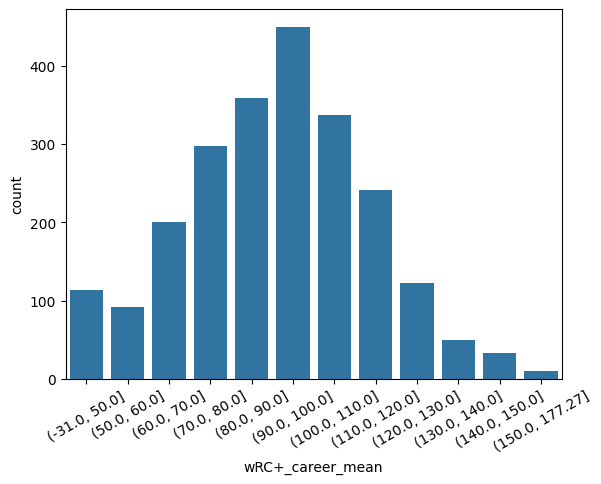

In [41]:
sns.countplot(x = wrc_counts)
plt.xticks(rotation = 30)
plt.show()

In [46]:
train_data, test_data = load_data(target = 'WAR')
print(train_data.shape)
print(test_data.shape)

(13540, 22)
(1452, 22)


In [47]:
war_data = add_career_mean(train_data, 'WAR')
war_data.head()

,IDfg,Season,Name,Age,G,PA,experience,WAR,WAR_lag,WAR_career_mean
0,1001649,1981,Al Bumbry,34,101,451,1.0,0.7,6.1,0.846381
1,1002689,1981,Al Cowens,29,85,284,1.0,0.6,0.2,0.786667
2,1009773,1981,Al Oliver,34,102,448,1.0,1.3,3.4,1.825994
3,1014234,1981,Al Woods,27,85,317,1.0,-0.2,2.4,-0.407565
4,1000336,1981,Alan Ashby,29,83,296,1.0,2.5,0.8,1.313733


In [48]:
player_data = war_data.loc[:, ['IDfg', 'WAR_career_mean']]
player_data = player_data.drop_duplicates()
player_data.shape

(2306, 2)

In [49]:
player_data.head()

,IDfg,WAR_career_mean
0,1001649,0.846381
1,1002689,0.786667
2,1009773,1.825994
3,1014234,-0.407565
4,1000336,1.313733


In [63]:
bins = [np.min(player_data['WAR_career_mean'].values)] + list(np.arange(0.0, 6.0, 0.5)) + [np.max(player_data['WAR_career_mean'].values)]
war_counts = pd.cut(player_data['WAR_career_mean'], bins)
war_counts

0         (0.5, 1.0]
1         (0.5, 1.0]
2         (1.5, 2.0]
3        (-2.7, 0.0]
4         (1.0, 1.5]
            ...     
13517     (1.0, 1.5]
13518     (1.5, 2.0]
13522     (0.0, 0.5]
13524     (3.0, 3.5]
13530    (-2.7, 0.0]
Name: WAR_career_mean, Length: 2306, dtype: category
Categories (13, interval[float64, right]): [(-2.7, 0.0] < (0.0, 0.5] < (0.5, 1.0] < (1.0, 1.5] ... (4.0, 4.5] < (4.5, 5.0] < (5.0, 5.5] < (5.5, 8.725]]

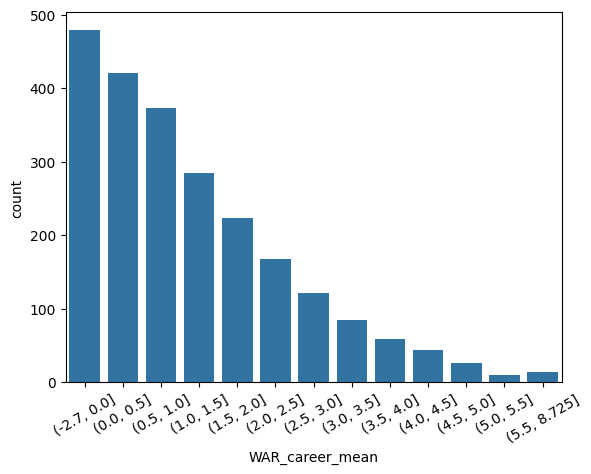

In [64]:
sns.countplot(x = war_counts)
plt.xticks(rotation = 30)
plt.show()

### Original wRC+ Aging Curve

In [65]:
train_data, test_data = load_data(target = 'wRC+')
print(train_data.shape)
print(test_data.shape)

(13540, 22)
(1452, 22)


In [66]:
wrc_data = add_career_mean(train_data, 'wRC+')
wrc_data.head()

,IDfg,Season,Name,Age,G,PA,experience,wRC+,wRC+_lag,wRC+_career_mean
0,1001649,1981,Al Bumbry,34,101,451,1.0,107,131.0,88.126911
1,1002689,1981,Al Cowens,29,85,284,1.0,91,87.0,96.489462
2,1009773,1981,Al Oliver,34,102,448,1.0,118,130.0,117.817251
3,1014234,1981,Al Woods,27,85,317,1.0,63,127.0,65.490775
4,1000336,1981,Alan Ashby,29,83,296,1.0,113,86.0,108.320983


In [67]:
features = ['Age', 'wRC+_career_mean', 'experience', 'wRC+_lag']
target = 'wRC+'

x, y = generate_data(wrc_data, feature_cols = features, target = target)

In [68]:
gam = GAM(te(0, 2, n_splines = 5, lam = 10) + s(1, n_splines = 5, lam = 10) + s(3, n_splines = 5, lam = 10))
gam.fit(x, y, weights = wrc_data['PA'].values)
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.2615
Link Function:                     IdentityLink Log Likelihood:                                -92142.1695
Number of Samples:                        13540 AIC:                                            184324.862
                                                AICc:                                          184324.9257
                                                GCV:                                           131335.5346
                                                Scale:                                         130999.2781
                                                Pseudo R-Squared:                                   0.6007
Feature Function                  Lam

C:\Users\citioplab\AppData\Local\Temp\ipykernel_46160\1497089973.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [69]:
age_lag_means = wrc_data.groupby(['Age'])['wRC+_lag'].mean()

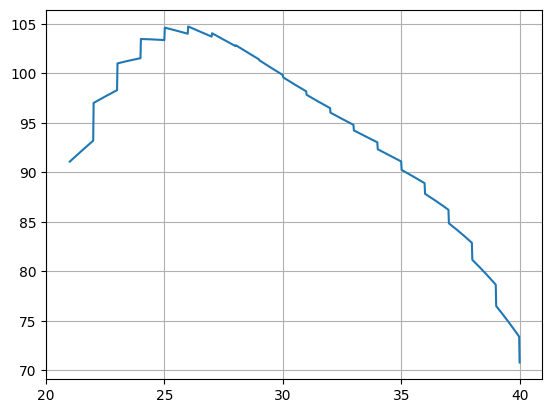

In [70]:
plt.figure()
XX = gam.generate_X_grid(term = 0, n = 1000)
XX[:, 1] = 100
XX[:, 2] = np.subtract(np.floor(XX[:, 0]), 20.0)

for i in range(21, 41):
    tmp = [age_lag_means[x] for x in np.floor(XX[:, 0])]
XX[:, 3] = tmp

plt.plot(XX[:, 0], gam.predict(XX))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()
# plt.plot(XX[:, 0], gam.partial_dependence(term = 0, X = XX,   width = .95)[1], c = 'r', ls = '--')

In [71]:
np.max(gam.predict(XX))

104.72882387376886

In [72]:
XX[np.argmax(gam.predict(XX)), 0]

26.002002002002

In [73]:
all_test_data = generate_test_data(wrc_data, test_data, 'wRC+')

In [74]:
all_test_data.head()

,IDfg,Season,Name,Age,G,PA,experience,wRC+_lag,wRC+,wRC+_career_mean
0,9256,2021,A.J. Pollock,33,117,422,8.0,107.0,137,117.510323
1,5297,2021,Aaron Hicks,31,32,126,8.0,103.0,77,104.298665
2,15640,2021,Aaron Judge,29,148,633,4.0,141.0,150,145.742857
3,5486,2021,Abraham Almonte,32,64,175,7.0,48.0,98,78.063910
4,13769,2021,Adalberto Mondesi,25,35,136,5.0,81.0,89,93.686649


In [75]:
evaluate(all_test_data, 'wRC+', gam)

19.489687780658297

In [82]:
strong_test_data = all_test_data.loc[all_test_data['wRC+_career_mean'] > 110, :]
strong_test_data.shape

(343, 10)

In [83]:
strong_test_data.head()

,IDfg,Season,Name,Age,G,PA,experience,wRC+_lag,wRC+,wRC+_career_mean
0,9256,2021,A.J. Pollock,33,117,422,8.0,107.0,137,117.510323
2,15640,2021,Aaron Judge,29,148,633,4.0,141.0,150,145.742857
6,11205,2021,Adam Eaton,32,84,288,9.0,108.0,68,114.373018
12,17678,2021,Alex Bregman,27,91,400,5.0,167.0,114,149.882731
13,12649,2021,Alex Dickerson,31,111,312,5.0,112.0,98,112.000000


In [84]:
evaluate(strong_test_data, 'wRC+', gam)

20.17992364529598

### Original WAR Aging Curve

In [85]:
train_data, test_data = load_data(target = 'WAR')
print(train_data.shape)
print(test_data.shape)

(13540, 22)
(1452, 22)


In [86]:
war_data = add_career_mean(train_data, 'WAR')
war_data.head()

,IDfg,Season,Name,Age,G,PA,experience,WAR,WAR_lag,WAR_career_mean
0,1001649,1981,Al Bumbry,34,101,451,1.0,0.7,6.1,0.846381
1,1002689,1981,Al Cowens,29,85,284,1.0,0.6,0.2,0.786667
2,1009773,1981,Al Oliver,34,102,448,1.0,1.3,3.4,1.825994
3,1014234,1981,Al Woods,27,85,317,1.0,-0.2,2.4,-0.407565
4,1000336,1981,Alan Ashby,29,83,296,1.0,2.5,0.8,1.313733


In [87]:
features = ['Age', 'WAR_career_mean', 'experience', 'WAR_lag']
target = 'WAR'

x, y = generate_data(war_data, feature_cols = features, target = target)

In [88]:
gam = GAM(te(0, 2, n_splines = 5, lam = 10) + s(1, n_splines = 5, lam = 10) + s(3, n_splines = 5, lam = 10))
gam.fit(x, y, weights = war_data['G'].values)
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     16.9904
Link Function:                     IdentityLink Log Likelihood:                                -26197.1677
Number of Samples:                        13540 AIC:                                            52430.3162
                                                AICc:                                           52430.3668
                                                GCV:                                              215.1521
                                                Scale:                                            214.6662
                                                Pseudo R-Squared:                                   0.5611
Feature Function                  Lam

C:\Users\citioplab\AppData\Local\Temp\ipykernel_46160\2913956295.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [89]:
age_lag_means = war_data.groupby(['Age'])['WAR_lag'].mean()

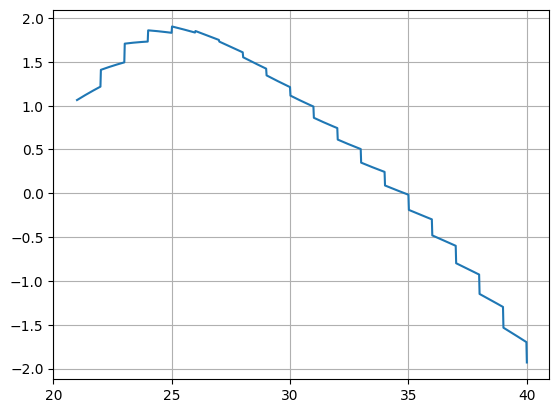

In [90]:
plt.figure()
XX = gam.generate_X_grid(term = 0, n = 1000)
XX[:, 1] = np.mean(war_data['WAR'])
XX[:, 2] = np.subtract(np.floor(XX[:, 0]), 20.0)

for i in range(21, 41):
    tmp = [age_lag_means[x] for x in np.floor(XX[:, 0])]
XX[:, 3] = tmp

plt.plot(XX[:, 0], gam.predict(XX))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()
# plt.plot(XX[:, 0], gam.partial_dependence(term = 0, X = XX,   width = .95)[1], c = 'r', ls = '--')

In [91]:
np.mean(war_data['WAR'])

1.4684121122599705

In [92]:
np.max(gam.predict(XX))

1.9040903718079083

In [93]:
XX[np.argmax(gam.predict(XX)), 0]

25.013013013013015

In [94]:
all_test_data = generate_test_data(war_data, test_data, 'WAR')

In [95]:
all_test_data.head()

,IDfg,Season,Name,Age,G,PA,experience,WAR_lag,WAR,WAR_career_mean
0,9256,2021,A.J. Pollock,33,117,422,8.0,0.5,3.2,3.438824
1,5297,2021,Aaron Hicks,31,32,126,8.0,0.6,0.1,1.874689
2,15640,2021,Aaron Judge,29,148,633,4.0,4.2,5.5,4.674286
3,5486,2021,Abraham Almonte,32,64,175,7.0,-0.8,-0.1,0.261153
4,13769,2021,Adalberto Mondesi,25,35,136,5.0,2.6,1.0,2.679292


In [96]:
evaluate(all_test_data, 'WAR', gam)

1.472874265005307

In [98]:
strong_test_data = all_test_data.loc[all_test_data['WAR_career_mean'] > 2.5, :]
strong_test_data.shape

(319, 10)

In [99]:
strong_test_data.head()

,IDfg,Season,Name,Age,G,PA,experience,WAR_lag,WAR,WAR_career_mean
0,9256,2021,A.J. Pollock,33,117,422,8.0,0.5,3.2,3.438824
2,15640,2021,Aaron Judge,29,148,633,4.0,4.2,5.5,4.674286
4,13769,2021,Adalberto Mondesi,25,35,136,5.0,2.6,1.0,2.679292
6,11205,2021,Adam Eaton,32,84,288,9.0,2.0,-0.6,3.317559
12,17678,2021,Alex Bregman,27,91,400,5.0,8.3,2.1,7.045374


In [100]:
evaluate(strong_test_data, 'WAR', gam)

1.771874569861796

Both models are less accurate in predicting the performance of top players. However, these players are more important to MLB teams and are more likely to sign long-term contracts. Therefore, I will be working on creating aging curves for the top players. Also, I will explore whether their aging curves differ from those of average players.

### wRC+ Aging Curve for Top Players

In [11]:
train_data, test_data = load_data(target = 'wRC+')
print(train_data.shape)
print(test_data.shape)

(13540, 22)
(1452, 22)


In [12]:
wrc_data = add_career_mean(train_data, 'wRC+')
wrc_data = wrc_data.loc[wrc_data['wRC+_career_mean'] > 110, :]
print(wrc_data.shape)

(3843, 10)


In [13]:
features = ['Age', 'wRC+_career_mean', 'experience', 'wRC+_lag']
target = 'wRC+'

x, y = generate_data(wrc_data, feature_cols = features, target = target)

In [14]:
gam = GAM(te(0, 2, n_splines = 5, lam = 10) + s(1, n_splines = 5, lam = 10) + s(3, n_splines = 5, lam = 10))
gam.fit(x, y, weights = wrc_data['PA'].values)
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     18.1416
Link Function:                     IdentityLink Log Likelihood:                                -26316.7125
Number of Samples:                         3843 AIC:                                            52671.7082
                                                AICc:                                           52671.9099
                                                GCV:                                           180406.3036
                                                Scale:                                         178873.9985
                                                Pseudo R-Squared:                                   0.3518
Feature Function                  Lam

C:\Users\citioplab\AppData\Local\Temp\ipykernel_21320\1497089973.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [15]:
age_lag_means = wrc_data.groupby(['Age'])['wRC+_lag'].mean()

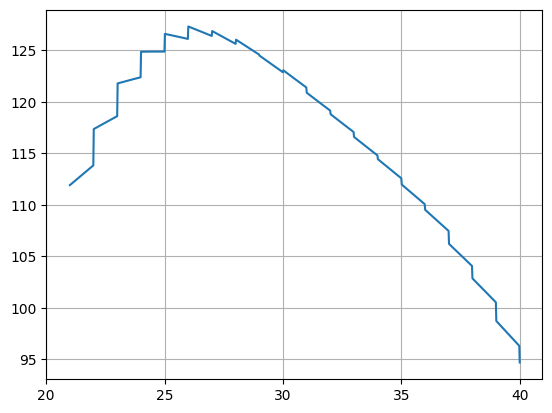

In [17]:
plt.figure()
XX = gam.generate_X_grid(term = 0, n = 1000)
XX[:, 1] = np.mean(wrc_data['wRC+'])
XX[:, 2] = np.subtract(np.floor(XX[:, 0]), 20.0)

for i in range(21, 41):
    tmp = [age_lag_means[x] for x in np.floor(XX[:, 0])]
XX[:, 3] = tmp

plt.plot(XX[:, 0], gam.predict(XX))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()
# plt.plot(XX[:, 0], gam.partial_dependence(term = 0, X = XX,   width = .95)[1], c = 'r', ls = '--')

In [18]:
np.max(gam.predict(XX))

127.32173128635289

In [19]:
XX[np.argmax(gam.predict(XX)), 0]

26.002002002002

In [21]:
all_test_data = generate_test_data(wrc_data, test_data, 'wRC+')
strong_test_data = all_test_data.loc[all_test_data['wRC+_career_mean'] > 110, :]
strong_test_data.shape

(343, 10)

In [22]:
strong_test_data.head()

,IDfg,Season,Name,Age,G,PA,experience,wRC+_lag,wRC+,wRC+_career_mean
0,9256,2021,A.J. Pollock,33,117,422,8.0,107.0,137,117.510323
1,15640,2021,Aaron Judge,29,148,633,4.0,141.0,150,145.742857
2,11205,2021,Adam Eaton,32,84,288,9.0,108.0,68,114.373018
3,17678,2021,Alex Bregman,27,91,400,5.0,167.0,114,149.882731
4,12649,2021,Alex Dickerson,31,111,312,5.0,112.0,98,112.000000


In [23]:
evaluate(strong_test_data, 'wRC+', gam)

19.980275030103435

After I focused on modeling the top batters specifically, the model's performance improved. Again, according to this model, batters are expected to reach the peak of their hitting ability by age 26. In addition, this aging curve closely resembles the original aging curve. Therefore, I speculate that the decline process for top batters is actually quite similar to that of average batters. The key difference is that top batters tend to perform better at the beginning of their careers, which means it takes them longer to drop below league average performance.

### WAR Aging Curve for Top players

In [11]:
train_data, test_data = load_data(target = 'WAR')
print(train_data.shape)
print(test_data.shape)

(13540, 22)
(1452, 22)


In [12]:
war_data = add_career_mean(train_data, 'WAR')
war_data = war_data.loc[war_data['WAR_career_mean'] > 2.5, :]
print(war_data.shape)

(3575, 10)


In [16]:
features = ['Age', 'WAR_career_mean', 'experience', 'WAR_lag']
target = 'WAR'

x, y = generate_data(war_data, feature_cols = features, target = target)

In [17]:
gam = GAM(te(0, 2, n_splines = 5, lam = 10) + s(1, n_splines = 5, lam = 10) + s(3, n_splines = 5, lam = 10))
gam.fit(x, y, weights = war_data['G'].values)
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.1238
Link Function:                     IdentityLink Log Likelihood:                                  -8000.462
Number of Samples:                         3575 AIC:                                            16033.1717
                                                AICc:                                           16033.3269
                                                GCV:                                              397.8642
                                                Scale:                                            394.8357
                                                Pseudo R-Squared:                                   0.3847
Feature Function                  Lam

C:\Users\citioplab\AppData\Local\Temp\ipykernel_43492\2913956295.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [18]:
age_lag_means = war_data.groupby(['Age'])['WAR_lag'].mean()

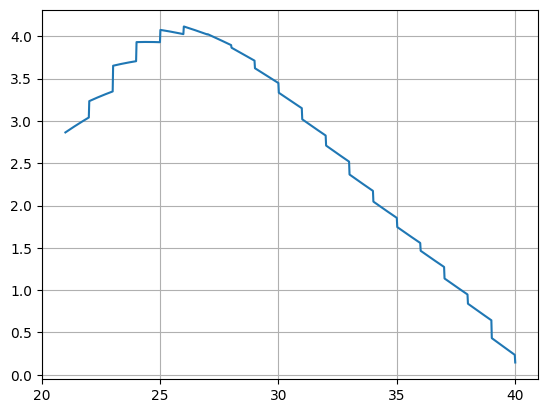

In [19]:
plt.figure()
XX = gam.generate_X_grid(term = 0, n = 1000)
XX[:, 1] = np.mean(war_data['WAR'])
XX[:, 2] = np.subtract(np.floor(XX[:, 0]), 20.0)

for i in range(21, 41):
    tmp = [age_lag_means[x] for x in np.floor(XX[:, 0])]
XX[:, 3] = tmp

plt.plot(XX[:, 0], gam.predict(XX))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()
# plt.plot(XX[:, 0], gam.partial_dependence(term = 0, X = XX,   width = .95)[1], c = 'r', ls = '--')

In [20]:
np.max(gam.predict(XX))

4.115091446861253

In [21]:
XX[np.argmax(gam.predict(XX)), 0]

26.002002002002

In [22]:
all_test_data = generate_test_data(war_data, test_data, 'WAR')
strong_test_data = all_test_data.loc[all_test_data['WAR_career_mean'] > 2.5, :]
strong_test_data.shape

(319, 10)

In [23]:
strong_test_data.head()

,IDfg,Season,Name,Age,G,PA,experience,WAR_lag,WAR,WAR_career_mean
0,9256,2021,A.J. Pollock,33,117,422,8.0,0.5,3.2,3.438824
1,15640,2021,Aaron Judge,29,148,633,4.0,4.2,5.5,4.674286
2,13769,2021,Adalberto Mondesi,25,35,136,5.0,2.6,1.0,2.679292
3,11205,2021,Adam Eaton,32,84,288,9.0,2.0,-0.6,3.317559
4,17678,2021,Alex Bregman,27,91,400,5.0,8.3,2.1,7.045374


In [24]:
evaluate(strong_test_data, 'WAR', gam)

1.746016489662477

I'm not sure why these top position players peaked in WAR at 26 years old, a year later than the previous WAR aging curve predicted. Consequently, I explored whether top position players are slower to reach their peak age in defensive contributions.

In [15]:
train_data, test_data = load_data(target = 'WAR')
war_data = add_career_mean(train_data, 'WAR')
train_idx = (war_data['WAR_career_mean'] > 2.5).values

#### Explore Denfensive Contribution

In [16]:
train_data, test_data = load_data(target = 'Def')
def_data = add_career_mean(train_data, 'Def')
def_data = def_data.loc[train_idx, :]

In [17]:
features = ['Age', 'Def_career_mean', 'experience', 'Def_lag']
target = 'Def'

x, y = generate_data(def_data, feature_cols = features, target = target)

In [18]:
gam = GAM(te(0, 2, n_splines = 5, lam = 10) + s(1, n_splines = 5, lam = 10) + s(3, n_splines = 5, lam = 10))
gam.fit(x, y, weights = def_data['G'].values)
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.4454
Link Function:                     IdentityLink Log Likelihood:                                -17536.9482
Number of Samples:                         3575 AIC:                                            35106.7873
                                                AICc:                                           35106.9486
                                                GCV:                                             6722.3951
                                                Scale:                                           6670.1372
                                                Pseudo R-Squared:                                   0.6068
Feature Function                  Lam

C:\Users\citioplab\AppData\Local\Temp\ipykernel_83920\1717189650.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [19]:
age_lag_means = def_data.groupby(['Age'])['Def_lag'].mean()

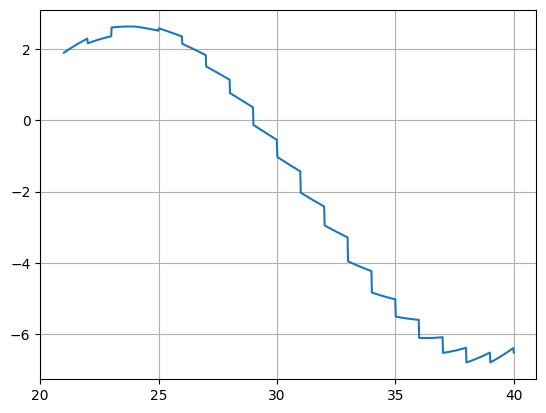

In [20]:
plt.figure()
XX = gam.generate_X_grid(term = 0, n = 1000)
XX[:, 1] = np.mean(def_data['Def'])
XX[:, 2] = np.subtract(np.floor(XX[:, 0]), 20.0)

for i in range(21, 41):
    tmp = [age_lag_means[x] for x in np.floor(XX[:, 0])]
XX[:, 3] = tmp

plt.plot(XX[:, 0], gam.predict(XX))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()
# plt.plot(XX[:, 0], gam.partial_dependence(term = 0, X = XX,   width = .95)[1], c = 'r', ls = '--')

In [21]:
np.max(gam.predict(XX))

2.623838786727177

In [22]:
XX[np.argmax(gam.predict(XX)), 0]

23.814814814814817

In [23]:
all_test_data = generate_test_data(def_data, test_data, 'Def')
strong_test_data = all_test_data.copy()
strong_test_data.shape

(319, 10)

In [24]:
evaluate(strong_test_data, 'Def', gam)

4.478429956573677

The aging curve indicates that top position players will peak defensively around age 24, nearly a year later than previously predicted. I consider that this is why their WAR peaked a year later.

To ensure accuracy, I verified if their attacking ability aging curve aligned with the previous two models.

In [25]:
train_data, test_data = load_data(target = 'wRC+')
wrc_data = add_career_mean(train_data, 'wRC+')
wrc_data = wrc_data.loc[train_idx, :]

In [26]:
features = ['Age', 'wRC+_career_mean', 'experience', 'wRC+_lag']
target = 'wRC+'

x, y = generate_data(wrc_data, feature_cols = features, target = target)

In [27]:
gam = GAM(te(0, 2, n_splines = 5, lam = 10) + s(1, n_splines = 5, lam = 10) + s(3, n_splines = 5, lam = 10))
gam.fit(x, y, weights = wrc_data['PA'].values)
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     17.8134
Link Function:                     IdentityLink Log Likelihood:                                -24266.6342
Number of Samples:                         3575 AIC:                                            48570.8953
                                                AICc:                                            48571.105
                                                GCV:                                           182549.3368
                                                Scale:                                         180912.7827
                                                Pseudo R-Squared:                                   0.4721
Feature Function                  Lam

C:\Users\citioplab\AppData\Local\Temp\ipykernel_83920\1497089973.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [29]:
age_lag_means = wrc_data.groupby(['Age'])['wRC+_lag'].mean()

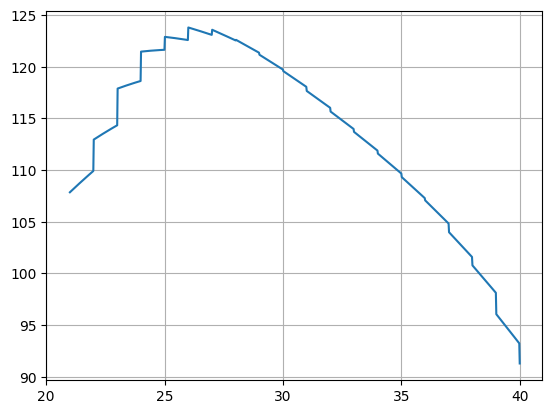

In [30]:
plt.figure()
XX = gam.generate_X_grid(term = 0, n = 1000)
XX[:, 1] = np.mean(wrc_data['wRC+'])
XX[:, 2] = np.subtract(np.floor(XX[:, 0]), 20.0)

for i in range(21, 41):
    tmp = [age_lag_means[x] for x in np.floor(XX[:, 0])]
XX[:, 3] = tmp

plt.plot(XX[:, 0], gam.predict(XX))
plt.xticks(np.arange(20, 45, 5))
plt.grid(True)
plt.show()
# plt.plot(XX[:, 0], gam.partial_dependence(term = 0, X = XX,   width = .95)[1], c = 'r', ls = '--')

In [31]:
np.max(gam.predict(XX))

123.80528088848749

In [32]:
XX[np.argmax(gam.predict(XX)), 0]

26.002002002002

In [33]:
all_test_data = generate_test_data(wrc_data, test_data, 'wRC+')
strong_test_data = all_test_data.copy()
strong_test_data.shape

(319, 10)

In [34]:
evaluate(strong_test_data, 'wRC+', gam)

20.24151865002655

This aging curve resembles the previous two. Thus, my earlier reasoning should still hold.